In [1]:
import librosa
import matplotlib.pyplot as plt

def plot_waveform(audio_path):
  y, sr = librosa.load(audio_path, sr=None)
  plt.figure(figsize=(14, 4))
  plt.plot(y)
  plt.title('Raw Waveform')
  plt.xlabel('Sample')
  plt.ylabel('Amplitude')
  plt.show()

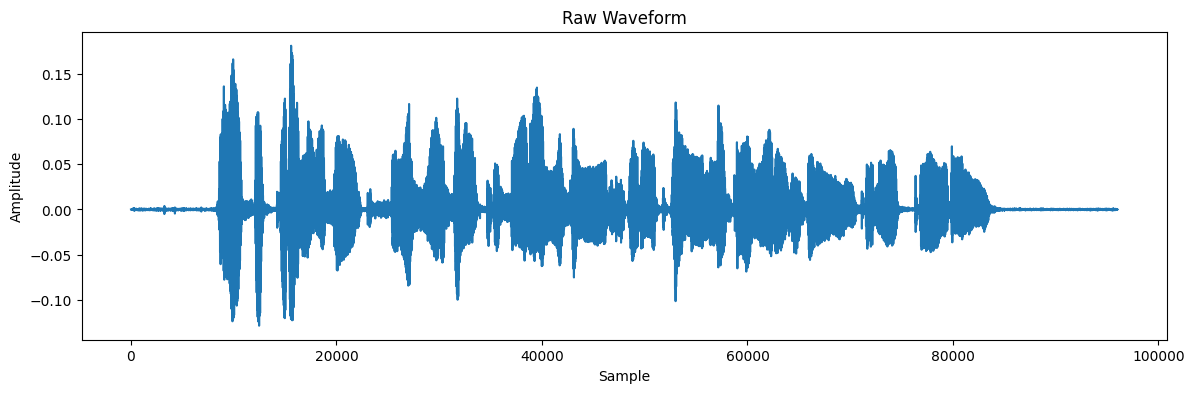

In [2]:
plot_waveform('D:/belajar/audio/vad/datasets/fleurs_speech/ar_eg_000005.wav')

In [ ]:
def energy_threshold(y):
  